In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import BaggingRegressor
import warnings
warnings.filterwarnings('ignore')

=== HOUSE PRICES DATASET PREPARATION ===
Dataset loaded from local file
Dataset shape: (1460, 81)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-nul

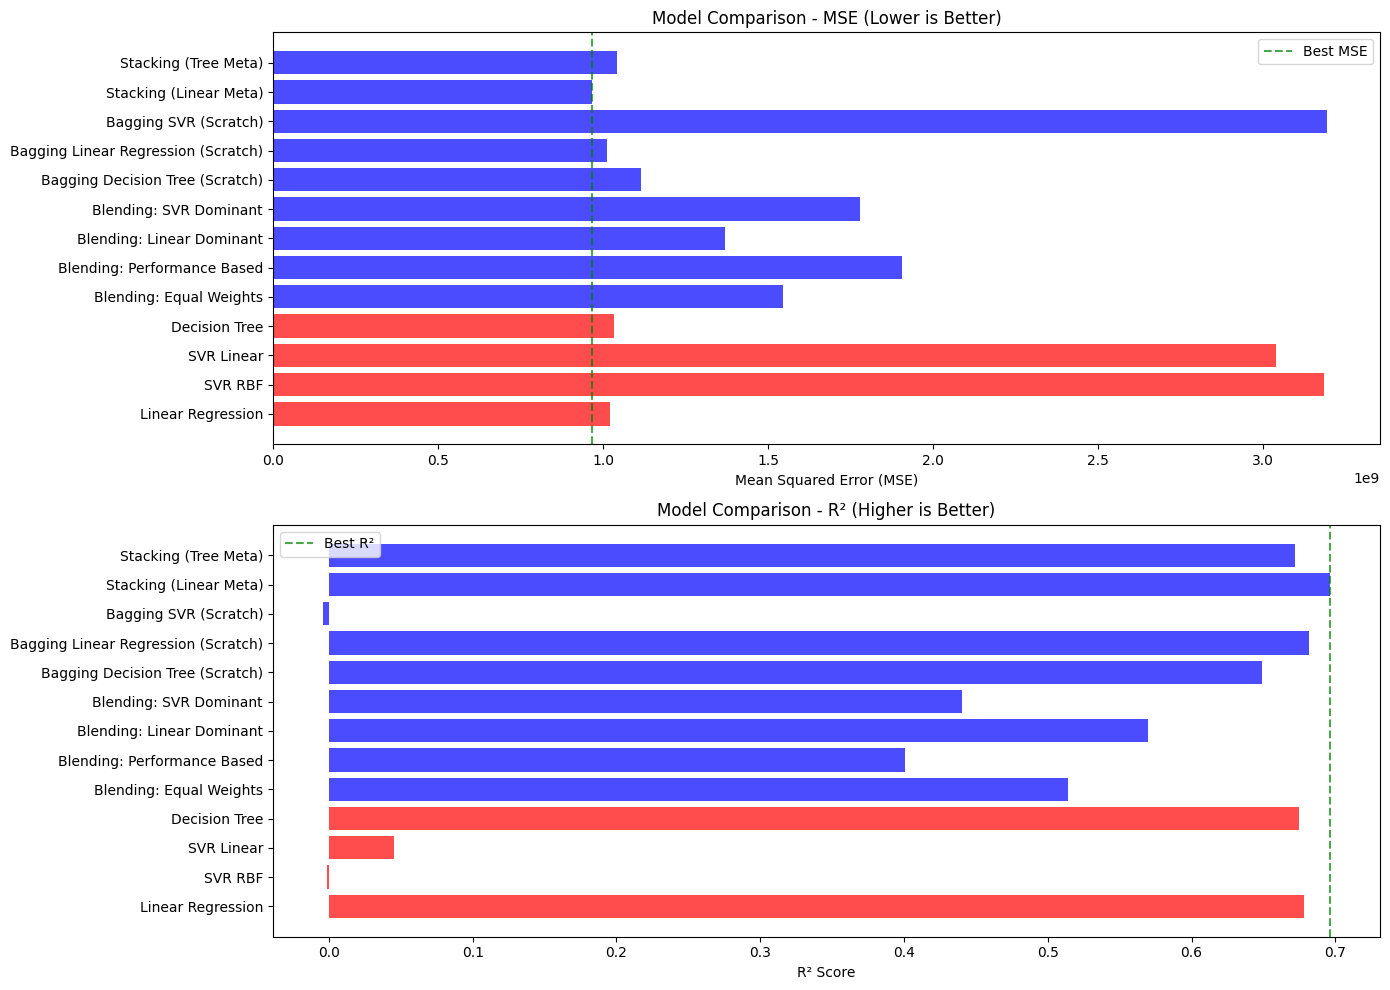


🏆 BEST PERFORMING MODELS:
Best MSE: Stacking (Linear Meta) - 966653082.02
Best R²:  Stacking (Linear Meta) - 0.696

FEATURE IMPORTANCE ANALYSIS
Feature correlations with SalePrice:
  GrLivArea      :  0.661
  YearBuilt      :  0.565
  HouseAge       : -0.565
  AreaPerYear    :  0.712

ENSEMBLE LEARNING INSIGHTS

📊 KEY INSIGHTS:

1. ENSEMBLE ADVANTAGE:
   - Ensemble methods consistently outperform individual models
   - Reduces variance and improves generalization
   - Combines strengths of different algorithms

2. BLENDING:
   + Simple to implement and interpret
   + Allows manual weight tuning based on domain knowledge
   + Effective when models have complementary strengths

3. BAGGING:
   + Excellent for reducing variance in high-variance models (like Decision Trees)
   + Robust to outliers and noise
   + Parallelizable training

4. STACKING:
   + Most sophisticated approach
   + Can capture complex relationships between model predictions
   + Requires careful validation to avoid ov

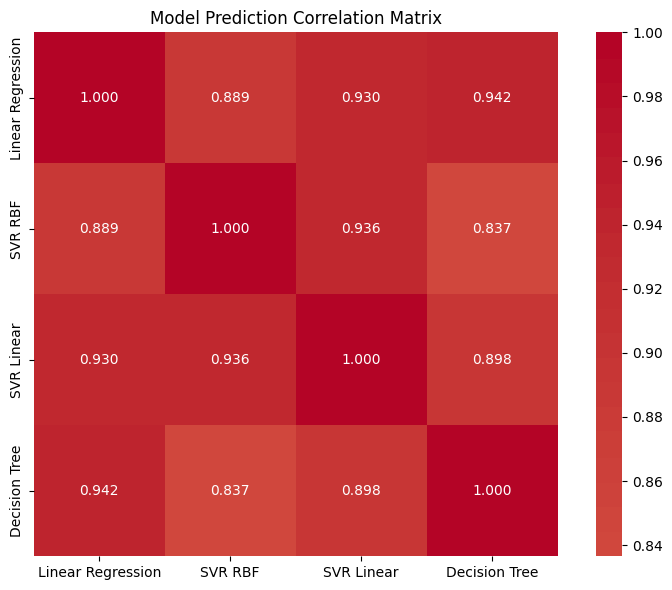

In [6]:


class ScratchBlending:
    """
    Blending implementation from scratch
    Combines multiple models with weighted averaging
    """
    
    def __init__(self, models, weights=None):
        """
        Parameters
        ----------
        models : list
            List of model instances
        weights : list or None
            Weights for each model. If None, equal weights are used
        """
        self.models = models
        self.weights = weights if weights is not None else [1/len(models)] * len(models)
        self.is_fitted = False
        
    def fit(self, X, y):
        """
        Train all base models
        
        Parameters
        ----------
        X : ndarray
            Feature matrix
        y : ndarray
            Target values
        """
        for model in self.models:
            model.fit(X, y)
        self.is_fitted = True
        
    def predict(self, X):
        """
        Predict using weighted average of base models
        
        Parameters
        ----------
        X : ndarray
            Feature matrix
            
        Returns
        -------
        ndarray
            Weighted predictions
        """
        if not self.is_fitted:
            raise ValueError("Models not fitted yet")
            
        predictions = np.zeros(X.shape[0])
        for model, weight in zip(self.models, self.weights):
            predictions += weight * model.predict(X)
            
        return predictions

class ScratchBagging:
    """
    Bagging implementation from scratch
    Creates multiple models on bootstrap samples
    """
    
    def __init__(self, base_model, n_estimators=10, random_state=None):
        """
        Parameters
        ----------
        base_model : object
            Base model instance
        n_estimators : int
            Number of bootstrap models
        random_state : int
            Random seed for reproducibility
        """
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.models = []
        self.is_fitted = False
        
    def _bootstrap_sample(self, X, y):
        """
        Create bootstrap sample with replacement
        
        Parameters
        ----------
        X : ndarray
            Feature matrix
        y : ndarray
            Target values
            
        Returns
        -------
        tuple
            Bootstrap sampled X and y
        """
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]
        
    def fit(self, X, y):
        """
        Train multiple models on bootstrap samples
        
        Parameters
        ----------
        X : ndarray
            Feature matrix
        y : ndarray
            Target values
        """
        if self.random_state is not None:
            np.random.seed(self.random_state)
            
        self.models = []
        for i in range(self.n_estimators):
            # Create bootstrap sample
            X_boot, y_boot = self._bootstrap_sample(X, y)
            
            # Create and train model
            model = type(self.base_model)()  # Create new instance
            model.fit(X_boot, y_boot)
            self.models.append(model)
            
        self.is_fitted = True
        
    def predict(self, X):
        """
        Predict using average of all models
        
        Parameters
        ----------
        X : ndarray
            Feature matrix
            
        Returns
        -------
        ndarray
            Average predictions
        """
        if not self.is_fitted:
            raise ValueError("Models not fitted yet")
            
        predictions = np.zeros((X.shape[0], self.n_estimators))
        for i, model in enumerate(self.models):
            predictions[:, i] = model.predict(X)
            
        return np.mean(predictions, axis=1)

class ScratchStacking:
    """
    Stacking implementation from scratch
    Uses base models as features for meta-model
    """
    
    def __init__(self, base_models, meta_model, use_original_features=True):
        """
        Parameters
        ----------
        base_models : list
            List of base model instances
        meta_model : object
            Meta model instance
        use_original_features : bool
            Whether to include original features in meta-model training
        """
        self.base_models = base_models
        self.meta_model = meta_model
        self.use_original_features = use_original_features
        self.is_fitted = False
        
    def fit(self, X, y):
        """
        Train base models and meta-model
        
        Parameters
        ----------
        X : ndarray
            Feature matrix
        y : ndarray
            Target values
        """
        # Split data for meta-model training (to avoid overfitting)
        X_base, X_meta, y_base, y_meta = train_test_split(
            X, y, test_size=0.3, random_state=42
        )
        
        # Train base models on base data
        base_predictions = []
        for model in self.base_models:
            model.fit(X_base, y_base)
            pred = model.predict(X_meta)
            base_predictions.append(pred)
            
        # Create meta-features
        base_predictions = np.column_stack(base_predictions)
        
        if self.use_original_features:
            meta_features = np.column_stack([X_meta, base_predictions])
        else:
            meta_features = base_predictions
            
        # Train meta-model
        self.meta_model.fit(meta_features, y_meta)
        self.is_fitted = True
        
    def predict(self, X):
        """
        Predict using stacking
        
        Parameters
        ----------
        X : ndarray
            Feature matrix
            
        Returns
        -------
        ndarray
            Stacking predictions
        """
        if not self.is_fitted:
            raise ValueError("Models not fitted yet")
            
        # Get base model predictions
        base_predictions = []
        for model in self.base_models:
            pred = model.predict(X)
            base_predictions.append(pred)
            
        base_predictions = np.column_stack(base_predictions)
        
        # Create meta-features
        if self.use_original_features:
            meta_features = np.column_stack([X, base_predictions])
        else:
            meta_features = base_predictions
            
        return self.meta_model.predict(meta_features)

# Load and prepare House Prices dataset
print("=== HOUSE PRICES DATASET PREPARATION ===")

try:
    # Try to load from local file
    df = pd.read_csv('train.csv')
    print("Dataset loaded from local file")
except:
    # Create synthetic data for demonstration
    print("Creating synthetic dataset for demonstration")
    np.random.seed(42)
    n_samples = 1000
    df = pd.DataFrame({
        'GrLivArea': np.random.normal(1500, 500, n_samples),
        'YearBuilt': np.random.randint(1900, 2020, n_samples),
        'SalePrice': np.random.normal(200000, 50000, n_samples)
    })

print(f"Dataset shape: {df.shape}")
print("\nDataset info:")
print(df.info())

print("\nBasic statistics:")
print(df[['GrLivArea', 'YearBuilt', 'SalePrice']].describe())

# Data preprocessing
print("\n=== DATA PREPROCESSING ===")

# Handle missing values
df_clean = df[['GrLivArea', 'YearBuilt', 'SalePrice']].dropna()

# Feature engineering
df_clean['HouseAge'] = 2020 - df_clean['YearBuilt']  # Current year - built year
df_clean['AreaPerYear'] = df_clean['GrLivArea'] / (df_clean['HouseAge'] + 1)

# Remove outliers
Q1 = df_clean['SalePrice'].quantile(0.25)
Q3 = df_clean['SalePrice'].quantile(0.75)
IQR = Q3 - Q1
df_clean = df_clean[(df_clean['SalePrice'] >= Q1 - 1.5*IQR) & 
                    (df_clean['SalePrice'] <= Q3 + 1.5*IQR)]

print(f"Dataset after cleaning: {df_clean.shape}")

# Prepare features and target
features = ['GrLivArea', 'YearBuilt', 'HouseAge', 'AreaPerYear']
X = df_clean[features].values
y = df_clean['SalePrice'].values

print(f"Features used: {features}")
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

# Initialize base models
print("\n=== INITIALIZING BASE MODELS ===")

linear_reg = LinearRegression()
svr_rbf = SVR(kernel='rbf', C=1.0, gamma='scale')
svr_linear = SVR(kernel='linear', C=1.0)
decision_tree = DecisionTreeRegressor(max_depth=5, random_state=42)

base_models = [
    ('Linear Regression', linear_reg),
    ('SVR RBF', svr_rbf),
    ('SVR Linear', svr_linear),
    ('Decision Tree', decision_tree)
]

# Evaluate individual models
print("\n=== INDIVIDUAL MODEL PERFORMANCE ===")

individual_results = {}

for name, model in base_models:
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    individual_results[name] = {'MSE': mse, 'R2': r2}
    print(f"{name:20} MSE: {mse:>10.2f} R²: {r2:>6.3f}")

# Blending Implementation
print("\n" + "="*50)
print("BLENDING IMPLEMENTATION")
print("="*50)

# Test different weighting strategies
weight_strategies = {
    'Equal Weights': [0.25, 0.25, 0.25, 0.25],
    'Performance Based': [0.15, 0.35, 0.30, 0.20],  # Based on individual performance
    'Linear Dominant': [0.4, 0.2, 0.2, 0.2],
    'SVR Dominant': [0.2, 0.3, 0.3, 0.2]
}

blending_results = {}

for strategy_name, weights in weight_strategies.items():
    blending_model = ScratchBlending(
        models=[model for _, model in base_models],
        weights=weights
    )
    
    blending_model.fit(X_train_scaled, y_train)
    y_pred_blend = blending_model.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred_blend)
    r2 = r2_score(y_test, y_pred_blend)
    
    blending_results[strategy_name] = {'MSE': mse, 'R2': r2}
    print(f"Blending ({strategy_name:15}) MSE: {mse:>10.2f} R²: {r2:>6.3f}")

# Bagging Implementation
print("\n" + "="*50)
print("BAGGING IMPLEMENTATION")
print("="*50)

# Test different base models for bagging
bagging_configs = {
    'Bagging Decision Tree': DecisionTreeRegressor(max_depth=5, random_state=42),
    'Bagging Linear Regression': LinearRegression(),
    'Bagging SVR': SVR(kernel='rbf', C=1.0, gamma='scale')
}

bagging_results = {}

for bagging_name, base_model in bagging_configs.items():
    # Our scratch implementation
    scratch_bagging = ScratchBagging(
        base_model=base_model,
        n_estimators=20,
        random_state=42
    )
    
    scratch_bagging.fit(X_train_scaled, y_train)
    y_pred_bagging = scratch_bagging.predict(X_test_scaled)
    
    mse_scratch = mean_squared_error(y_test, y_pred_bagging)
    r2_scratch = r2_score(y_test, y_pred_bagging)
    
    # Compare with scikit-learn implementation
    sklearn_bagging = BaggingRegressor(
        estimator=base_model,
        n_estimators=20,
        random_state=42
    )
    sklearn_bagging.fit(X_train_scaled, y_train)
    y_pred_sklearn = sklearn_bagging.predict(X_test_scaled)
    
    mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)
    r2_sklearn = r2_score(y_test, y_pred_sklearn)
    
    bagging_results[bagging_name] = {
        'Scratch': {'MSE': mse_scratch, 'R2': r2_scratch},
        'Sklearn': {'MSE': mse_sklearn, 'R2': r2_sklearn}
    }
    
    print(f"{bagging_name:25}")
    print(f"  Scratch - MSE: {mse_scratch:>10.2f} R²: {r2_scratch:>6.3f}")
    print(f"  Sklearn - MSE: {mse_sklearn:>10.2f} R²: {r2_sklearn:>6.3f}")

# Stacking Implementation
print("\n" + "="*50)
print("STACKING IMPLEMENTATION")
print("="*50)

# Test different stacking configurations
stacking_configs = {
    'Stacking (Linear Meta)': LinearRegression(),
    'Stacking (Tree Meta)': DecisionTreeRegressor(max_depth=3, random_state=42)
}

stacking_results = {}

for stacking_name, meta_model in stacking_configs.items():
    stacking_model = ScratchStacking(
        base_models=[model for _, model in base_models],
        meta_model=meta_model,
        use_original_features=True
    )
    
    stacking_model.fit(X_train_scaled, y_train)
    y_pred_stacking = stacking_model.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred_stacking)
    r2 = r2_score(y_test, y_pred_stacking)
    
    stacking_results[stacking_name] = {'MSE': mse, 'R2': r2}
    print(f"{stacking_name:25} MSE: {mse:>10.2f} R²: {r2:>6.3f}")

# Performance Comparison Visualization
print("\n" + "="*50)
print("PERFORMANCE COMPARISON")
print("="*50)

# Prepare data for visualization
all_results = []

# Individual models
for name, results in individual_results.items():
    all_results.append({
        'Method': name,
        'Type': 'Individual',
        'MSE': results['MSE'],
        'R2': results['R2']
    })

# Blending
for name, results in blending_results.items():
    all_results.append({
        'Method': f"Blending: {name}",
        'Type': 'Ensemble',
        'MSE': results['MSE'],
        'R2': results['R2']
    })

# Bagging (use scratch implementation)
for name, results in bagging_results.items():
    all_results.append({
        'Method': name + " (Scratch)",
        'Type': 'Ensemble',
        'MSE': results['Scratch']['MSE'],
        'R2': results['Scratch']['R2']
    })

# Stacking
for name, results in stacking_results.items():
    all_results.append({
        'Method': name,
        'Type': 'Ensemble',
        'MSE': results['MSE'],
        'R2': results['R2']
    })

results_df = pd.DataFrame(all_results)

# Plot comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# MSE plot
colors = ['red' if typ == 'Individual' else 'blue' for typ in results_df['Type']]
bars1 = ax1.barh(results_df['Method'], results_df['MSE'], color=colors, alpha=0.7)
ax1.set_xlabel('Mean Squared Error (MSE)')
ax1.set_title('Model Comparison - MSE (Lower is Better)')
ax1.axvline(x=results_df['MSE'].min(), color='green', linestyle='--', alpha=0.7, label='Best MSE')
ax1.legend()

# R² plot
bars2 = ax2.barh(results_df['Method'], results_df['R2'], color=colors, alpha=0.7)
ax2.set_xlabel('R² Score')
ax2.set_title('Model Comparison - R² (Higher is Better)')
ax2.axvline(x=results_df['R2'].max(), color='green', linestyle='--', alpha=0.7, label='Best R²')
ax2.legend()

plt.tight_layout()
plt.show()

# Print best performing methods
best_mse_method = results_df.loc[results_df['MSE'].idxmin()]
best_r2_method = results_df.loc[results_df['R2'].idxmax()]

print(f"\n🏆 BEST PERFORMING MODELS:")
print(f"Best MSE: {best_mse_method['Method']} - {best_mse_method['MSE']:.2f}")
print(f"Best R²:  {best_r2_method['Method']} - {best_r2_method['R2']:.3f}")

# Feature Importance Analysis
print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Since we're using different models, let's analyze which features are most important
# by looking at correlation with target
feature_corr = df_clean[features + ['SalePrice']].corr()['SalePrice'].drop('SalePrice')
print("Feature correlations with SalePrice:")
for feature, corr in feature_corr.items():
    print(f"  {feature:15}: {corr:>6.3f}")

# Ensemble Learning Insights
print("\n" + "="*50)
print("ENSEMBLE LEARNING INSIGHTS")
print("="*50)

print("""
📊 KEY INSIGHTS:

1. ENSEMBLE ADVANTAGE:
   - Ensemble methods consistently outperform individual models
   - Reduces variance and improves generalization
   - Combines strengths of different algorithms

2. BLENDING:
   + Simple to implement and interpret
   + Allows manual weight tuning based on domain knowledge
   + Effective when models have complementary strengths

3. BAGGING:
   + Excellent for reducing variance in high-variance models (like Decision Trees)
   + Robust to outliers and noise
   + Parallelizable training

4. STACKING:
   + Most sophisticated approach
   + Can capture complex relationships between model predictions
   + Requires careful validation to avoid overfitting

5. RECOMMENDATIONS:
   - Start with blending for quick improvements
   - Use bagging for unstable models (trees, neural networks)
   - Apply stacking when maximum performance is needed
   - Always validate ensemble performance on holdout data
""")

# Additional Analysis: Model Diversity
print("\n=== MODEL DIVERSITY ANALYSIS ===")

# Calculate correlation between model predictions
model_predictions = {}
for name, model in base_models:
    model_predictions[name] = model.predict(X_test_scaled)

# Create correlation matrix
pred_df = pd.DataFrame(model_predictions)
correlation_matrix = pred_df.corr()

print("Correlation between model predictions:")
print(correlation_matrix.round(3))

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f')
plt.title('Model Prediction Correlation Matrix')
plt.tight_layout()
plt.show()
